# Station Matching

The goal of this notebook is to identify stations that changed IDs. This has been known to occur for Maritime and ASOSOAWOS stations.


## Environment set-up

In [9]:
from shapely.geometry import Point
from shapely.ops import nearest_points

from functools import reduce
import datetime
from pandas import *
import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO, StringIO

import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket

import s3fs

# import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(
    "ignore", category=ShapelyDeprecationWarning
)  # Warning is raised when creating Point object from coords. Can't figure out why.

plt.rcParams["figure.dpi"] = 300

In [10]:
# AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")

## AWS buckets
bucket = "wecc-historical-wx"
qaqcdir = "3_qaqc_wx/"
mergedir = "4_merge_wx/"

In [11]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary
temp_dir = "./tmp"
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [12]:
def read_nc_from_s3_clean(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    I'd like to see us use a zarr workflow if possible to avoid this.

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".nc", delete=True
    )

    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/2_clean_wx/{}/{}.nc".format(
        network_name, station_id
    )

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="h5netcdf").load()

    # Close temporary file
    temp_file.close()

    return station_data

In [13]:
def read_zarr_from_s3(station_id, temp_dir):
    """Read zarr file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".zarr", delete=True
    )

    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_{}.zarr".format(
        station_id
    )
    print(s3_url)

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="zarr").load()

    # Close temporary file
    temp_file.close()

    return station_data

In [14]:
def qaqc_ds_to_df(ds, verbose=False):
    """Converts xarray ds for a station to pandas df in the format needed for the pipeline

    Parameters
    ----------
    ds : xr.Dataset
        input data from the clean step
    verbose : bool, optional
        if True, provides runtime output to the terminal

    Returns
    -------
    df : pd.DataFrame
        converted xr.Dataset into dataframe
    MultiIndex : pd.Index
        multi-index of station and time
    attrs : list of str
        attributes from xr.Dataset
    var_attrs : list of str
        variable attributes from xr.Dataset
    era_qc_vars : list of str
        QAQC variables

    Notes
    -----
    This is the notebook friendly version (no logger statements).
    """
    ## Add qc_flag variable for all variables, including elevation;
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key, val in ds.variables.items():
        if val.dtype == object:
            if key == "station":
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)

    exclude_qaqc = [
        "time",
        "station",
        "lat",
        "lon",
        "qaqc_process",
        "sfcWind_method",
        "pr_duration",
        "pr_depth",
        "PREC_flag",
        "rsds_duration",
        "rsds_flag",
        "anemometer_height_m",
        "thermometer_height_m",
    ]  # lat, lon have different qc check

    raw_qc_vars = []  # qc_variable for each data variable, will vary station to station
    era_qc_vars = []  # our ERA qc variable
    old_era_qc_vars = []  # our ERA qc variable

    for var in ds.data_vars:
        if "q_code" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variable, need to keep for comparison, then drop
        if "_qc" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
        if "_eraqc" in var:
            era_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
            old_era_qc_vars.append(var)

    print(f"era_qc existing variables:\n{era_qc_vars}")
    n_qc = len(era_qc_vars)

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc"  # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                print(f"nans created for {qc_var}")
                ds = ds.assign({qc_var: xr.ones_like(ds[var]) * np.nan})
                era_qc_vars.append(qc_var)

    print("{} created era_qc variables".format(len(era_qc_vars) - len(old_era_qc_vars)))
    if len(era_qc_vars) != n_qc:
        print("{}".format(np.setdiff1d(old_era_qc_vars, era_qc_vars)))

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    # var_attrs = {var: ds[var].attrs for var in list(ds.data_vars.keys())}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df = ds.to_dataframe()

    # instrumentation heights
    if "anemometer_height_m" not in df.columns:
        try:
            df["anemometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.anemometer_height_m
            )
        except:
            print("Filling anemometer_height_m with NaN.", flush=True)
            df["anemometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass
    if "thermometer_height_m" not in df.columns:
        try:
            df["thermometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.thermometer_height_m
            )
        except:
            print("Filling thermometer_height_m with NaN.", flush=True)
            df["thermometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()

    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df["station"] = station

    # Station pd.Series to str
    station = station.unique().values[0]

    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    df["day"] = pd.to_datetime(df["time"]).dt.day
    df["month"] = pd.to_datetime(df["time"]).dt.month
    df["year"] = pd.to_datetime(df["time"]).dt.year
    df["date"] = pd.to_datetime(df["time"]).dt.date

    return df  # , MultiIndex, attrs, var_attrs, era_qc_vars

## Step 1: Identify candidates for concatenation and upload to AWS

We do so by identifying stations with exactly matching latitudes and longitudes.

In [43]:
# A list of networks to be checked for concatenation
target_networks = ["ASOSAWOS","VALLEYWATER", "MARITIME"]

In [15]:
def concatenation_check(station_list):
    """
    This function flags stations that need to be concatenated.

    Rules
    ------
        1.) Stations are flagged if they have identical latitudes and longitudes

    Parameters
    ------
        station_list: pd.DataFrame
            list of station information

    Returns
    -------
        if success:
            new_station_list: pd.DataFrame
                input station list with a flag column assigning an integer to each group of repeat latitudes and longitudes

        if failure:
            None

    """
    ##### Flag stations with identical latitudes and longitudes, then assign each group a unique integer

    # List of possible variable names for longitudes and latitudes
    lat_lon_list = ["LAT", "LON", "latitude", "longitude", "LATITUDE", "LONGITUDE", 'lat','lon']
    # Extract the latitude and longitude variable names from the input dataframe
    lat_lon_cols = [col for col in station_list.columns if col in lat_lon_list]

    # Generate column flagging duplicate latitudes and longitudes
    station_list["concat_subset"] = station_list.duplicated(
        subset=lat_lon_cols, keep=False
    )
    # within each group of identical latitudes and longitudes, assign a unique integer
    station_list["concat_subset"] = (
        station_list[station_list["concat_subset"] == True].groupby(lat_lon_cols).ngroup()
    )

    ##### Order station list by flag
    concat_station_list = station_list.sort_values("concat_subset")

    ##### Keep only flagged stations
    concat_station_list = concat_station_list[~concat_station_list["concat_subset"].isna()]

    ##### Format final list
    # Convert flags to integers - this is necessary for the final concatenation step
    concat_station_list["concat_subset"] = concat_station_list["concat_subset"].astype(
        "int32"
    )
    # Now keep only the ERA-ID and flag column
    era_id_list = ['ERA-ID','era-id']
    era_id_col = [col for col in station_list.columns if col in era_id_list]
    concat_station_list = concat_station_list[era_id_col + ["concat_subset"]]

    # Standardize ERA id to "ERA-ID" (this is specific to Valleywater stations)
    if 'era-id' in era_id_col:
        concat_station_list.rename(columns={"era-id": "ERA-ID"}, inplace=True)

    return concat_station_list

In [44]:
def apply_concat_check(station_names_list):
    """
    This function applies the conatenation check to a list of target stations. 
    It then upload a csv containing the ERA IDs and concatenation subset ID for 
    all identified stations in a network.

    Parameters
    ------
        station__names_list: pd.DataFrame
            list of target station names

    Returns
    -------
        if success:
            uploads list of stations to be concatenated to AWS
        if failure:
            None

    """
    final_list = pd.DataFrame([])
    for station in station_names_list:

        ##### Import station list of target station
        key = "2_clean_wx/{}/stationlist_{}_cleaned.csv".format(station,station)
        bucket_name = "wecc-historical-wx"
        list_import = s3_cl.get_object(
            Bucket=bucket,
            Key=key,
        )
        station_list = pd.read_csv(BytesIO(list_import["Body"].read()))

        ##### Apply concatenation check
        concat_list = concatenation_check(station_list)

        ##### Rename the flags for each subset to <station>_<subset number>
        concat_list["concat_subset"] = station + '_' + concat_list["concat_subset"].astype(str)

        ##### Append to final list of stations to concatenate
        final_list = pd.concat([final_list,concat_list])

        ##### Upload to QAQC directory in AWS
        new_buffer = StringIO()
        final_list.to_csv(new_buffer, index = False)
        content = new_buffer.getvalue()

        # the csv is stored in each station folder within 3_qaqc_wx
        s3_cl.put_object(
            Bucket = bucket_name,
            Body = content,
            Key = qaqcdir + station + "/concat_list_{}.csv".format(station)
        )
        
    return None

In [45]:
apply_concat_check(target_networks)

## Step 2: Concatenate Stations

In [18]:
# Lists of variables to be assigned

float64_variables = [
    "anemometer_height_m",
    "elevation",
    "lat",
    "lon",
    "pr_15min",
    "thermometer_height_m",
    "ps",
    "tas",
    "tdps",
    "pr",
    "sfcWind",
    "sfcWind_dir",
    "ps_altimeter",
    "pr_duration",
    "ps_eraqc",
    "tas_eraqc",
    "tdps_eraqc",
    "pr_eraqc",
    "sfcWind_eraqc",
    "sfcWind_dir_eraqc",
    "elevation_eraqc",
    "ps_altimeter_eraqc",
    "pr_15min_eraqc",
]
U16_variables = [
    #"raw_qc",
    "qaqc_process",
    "ps_qc",
    "ps_altimeter_qc",
    "psl_qc",
    "tas_qc",
    "tdps_qc",
    "pr_qc",
    "pr_depth_qc",
    "sfcWind_qc",
    "sfcWind_method",
    "sfcWind_dir_qc",
]


In [19]:
def convert_datatypes(ds):
    """
    Converts the datatypes of variables in a dataset based on external libraries. 
    Used in the station concatenation function.

    Parameters
    ------
        ds: xr.Dataset
            weather station network

    Returns
    -------
        if success:
            output dataset with coverted datatypes
        if failure:
            None
    Notes
    -------
    Uses the following externally defined dictionaries to assign datatypes to variables:
    float32_variables: List
            list of variables that will be converted to datatpe "float64"
    U16_variables: List
            list of variables that will be converted to datatpe "<U16"
    """
    # Generate lists of variables from the external dicionaries that are actually present in the input dataset
    existing_float64 = [
        key for key in float64_variables if key in list(ds.keys())
    ]
    existing_U16 = [key for key in U16_variables if key in list(ds.keys())]

    # Convert the datatypes of those variables, but only if those variables exist
    if len(existing_float64) == 0:
        pass
    else:
        ds[existing_float64] = ds[existing_float64].astype("float64")
    
    if len(existing_U16) == 0:
        pass
    else: 
        ds[existing_U16] = ds[existing_U16].astype("<U16")

    # And of the coordinates as well
    ds.coords["station"] = ds.coords["station"].astype("<U16")

    return ds

In [ ]:
def concatenate_station_pairs(network_name):
    """
    Concatenates two input datasets, deletes the originals, and exports the final concatenated dataset. 
    Also returns a list of the ERA-IDs of all stations that are concatenated.

    Rules
    ------
        1.) concatenation: keep the newer station data in the time range in which both stations overlap

    Parameters
    ------
        network_name: string
            weather station network

    Returns
    -------
        if success: 
            return list of ERA-IDs are stations that are concatenated
            all processed datasets are exported to the merge folder in AWS and the original datasets are deleted
        if failure:
            None
    """
    ##### Read in concatenation list of input network
    network_list = s3_cl.get_object(
        Bucket=bucket,
        Key="3_qaqc_wx/{}/concat_list_{}.csv".format(
            network_name, network_name, network_name
        ),
    )
    concat_list = pd.read_csv(BytesIO(network_list["Body"].read()))

    subset_number = len(concat_list['concat_subset'].unique())

    # initiate empty list, to which we will iteratively add the ERA-IDs of stations that are concatenated
    final_concat_list = []

    for i in range(0,subset_number):

        # count the number of staions in subset i
        subset_i = concat_list[
            concat_list["concat_subset"].str.contains("{}".format(i))
        ]

        n = subset_i.count()[0]

        # if there are only two stations, proceed with concatenation
        if n == 2:
            # retrieve ERA IDs in this subset of stations
            station_1 = subset_i["ERA-ID"].iloc[0]
            station_2 = subset_i["ERA-ID"].iloc[1]
            
            final_concat_list.append(station_1)
            final_concat_list.append(station_2)
            try: 
                # import this subset of datasets and convert to dataframe
                url_1 = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}.zarr".format(
                    network_name, station_1
                )
                url_2 = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}.zarr".format(
                    network_name, station_2
                )

                # TODO: open_zarr will be used for QAQC'd datasets
                ds_1 = xr.open_zarr(url_1)
                ds_2 = xr.open_zarr(url_2)
            exception:

            df_1 = ds_1.to_dataframe()
            df_2 = ds_2.to_dataframe()

            # apply reset index only to 'time', as we will need that for concatenation
            df_1 = df_1.reset_index(level="time")
            df_2 = df_2.reset_index(level="time")

            # determine which dataset is older
            if df_1["time"].max() < df_2["time"].max(): 
                # if df_1 has an earlier end tiem than df_2, then d_2 is newer
                # we also grab the name of the newer station in this step, for use later
                df_new = df_2
                ds_new = ds_2

                df_old = df_1
                ds_old = ds_1
            else:
                df_new = df_1
                ds_new = ds_1

                df_old = df_2
                ds_old = ds_2

            # now set things up to determine if there is temporal overlap between df_new and df_old
            df_overlap = df_new[df_new["time"].isin(df_old["time"])]

            # if there is no overlap between the two time series, just concatenate
            if len(df_overlap) == 0:
                df_concat = concat([df_old, df_new])

            # if not, split into subsets and concatenate
            else: 
                ##### Split datframes into subsets #####

                # Remove data in time overlap between old and new
                df_old_cleaned = df_old[~df_old["time"].isin(df_overlap["time"])]
                df_new_cleaned = df_new[~df_new["time"].isin(df_overlap["time"])]

                ##### Concatenate subsets #####
                df_concat = concat([df_old_cleaned, df_overlap, df_new_cleaned])

            ##### Now prepare the final concatenated dataframe for export
            station_name_new = ds_new.coords["station"].values[0]
            final_station_name = "{}".format(station_name_new)
            new_index = [final_station_name] * len(df_concat)
            df_concat.index = new_index
            df_concat.index.name = "station"

            # drop duplicate rows that were potentially generated in the concatenation process
            df_concat = df_concat.drop_duplicates(subset=["time"])

            # Add 'time' back into multi index
            df_concat.set_index("time", append=True, inplace=True)

            # Convert concatenated dataframe to dataset
            ds_concat = df_concat.to_xarray()

            #### Update attributes and datatypes #####

            # Include past attributes
            ds_concat.attrs = ds_new.attrs

            # Update 'history' attribute
            timestamp = datetime.datetime.utcnow().strftime("%m-%d-%Y, %H:%M:%S")
            ds_concat.attrs["history"] = ds_new.attrs[
                "history"
            ] + " \n maritime_merge.ipynb run on {} UTC".format(timestamp)

            # Update 'comment' attribute
            ds_concat.attrs["comment"] = (
                "Final v1 data product. This data has been subjected to cleaning, QA/QC, and standardization."
            )

            # Add new qaqc_files_merged attribute
            station_name_old = ds_old.coords["station"].values[0]
            ds_concat.attrs["qaqc_files_merged"] = (
                "{}_{}, {}_{} merged. Overlap retained from newer station data.".format(
                    network_name, station_name_old, network_name, station_name_new
                )
            )

            # Convert all datatypes, to enable export
            ds_concat = convert_datatypes(ds_concat)

            # ## Export ###
            # export_url = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}_{}.zarr".format(
            #     network_name, "test_concat", network_name # station_name_new
            # )
            # ds_concat.to_zarr(export_url, mode="w")

        # if there are more than two stations in the subset, continue
        else:
            continue

    # return final_concat_list  
    return df_concat, df_new, df_old, ds_concat

### CHECK

#### Check option 1

run concatenate_station_pairs() as is, so the function does not export and instead returns df_concat, df_new, df_old, and df_overlap

In [55]:
network_name = "ASOSAWOS"
df_concat, df_new, df_old, ds_concat = concatenate_station_pairs(network_name)

GroupNotFoundError: group not found at path ''

In [ ]:
# extract time index for plotting
df_new = df_new.reset_index(level="time")
df_old = df_old.reset_index(level="time")


df_concat = df_concat.reset_index(level="time")

#### Check option 2

Run concatenate_station_pairs() with the first return statement uncommented and the second commented, and the export section uncommented. So that the function actually exports the concatenated datasets. I've generated all the concatention lists (for VALLEYWATER, MARITIME, and ASOSAWOS) needed to run the function.

In [ ]:
network_name = "VALLEYWATER"
output = concatenate_station_pairs(network_name)

In [ ]:
network_list = s3_cl.get_object(
    Bucket=bucket,
    Key="3_qaqc_wx/{}/{}_concat_list_TEST.csv".format(
        network_name, network_name, network_name
    ),
)
concat_list = pd.read_csv(BytesIO(network_list["Body"].read()))
station_1 = concat_list["ERA-ID"].iloc[0]
station_2 = concat_list["ERA-ID"].iloc[1]

# import this subset of datasets and convert to dataframe
url_1 = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}.zarr".format(network_name, station_1)
url_2 = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}.zarr".format(network_name, station_2)

ds_1 = xr.open_zarr(url_1)
ds_2 = xr.open_zarr(url_2)

df_1 = ds_1.to_dataframe()
df_2 = ds_2.to_dataframe()

In [ ]:
# import output
url_output = "s3://wecc-historical-wx/3_qaqc_wx/{}/concat_list_{}.zarr".format(
    network_name, network_name
)

# TODO: open_zarr will be used for QAQC'd datasets
ds_concat = xr.open_zarr(url_output)

df_concat = ds_concat.to_dataframe()

In [ ]:
# extract time index for plotting
df_1 = df_1.reset_index(level="time")
df_2 = df_2.reset_index(level="time")


df_concat = df_concat.reset_index(level="time")

In [ ]:
if df_1["time"].max() < df_2["time"].max(): 
    # if df_1 has an earlier end tiem than df_2, then d_2 is newer
    # we also grab the name of the newer station in this step, for use later
    df_new = df_2
    ds_new = ds_2

    df_old = df_1
    ds_old = ds_1
else:
    df_new = df_1
    ds_new = ds_1

    df_old = df_2
    ds_old = ds_2

#### Onward

In [50]:
df_concat.head(4)

,time,anemometer_height_m,elevation,elevation_eraqc,lat,lon,pr,pr_depth_qc,pr_duration,pr_eraqc,...,sfcWind_eraqc,sfcWind_method,sfcWind_qc,tas,tas_eraqc,tas_qc,tdps,tdps_eraqc,tdps_qc,thermometer_height_m
station,,,,,,,,,,,,,,,,,,,,,
ASOSAWOS_72269593041,2002-09-02 06:59:00,NaN,1358.0,NaN,32.283,-106.916,NaN,NaN,NaT,NaN,...,NaN,9,9,19.0,NaN,9,19.0,28.0,9,NaN
ASOSAWOS_72269593041,2002-09-03 06:59:00,NaN,1358.0,NaN,32.283,-106.916,NaN,NaN,NaT,NaN,...,NaN,9,9,19.0,NaN,9,19.0,28.0,9,NaN
ASOSAWOS_72269593041,2002-09-04 06:59:00,NaN,1358.0,NaN,32.283,-106.916,NaN,NaN,NaT,NaN,...,NaN,9,9,19.0,NaN,9,19.0,28.0,9,NaN
ASOSAWOS_72269593041,2002-09-05 06:59:00,NaN,1358.0,NaN,32.283,-106.916,NaN,NaN,NaT,NaN,...,NaN,9,9,19.0,NaN,9,19.0,28.0,9,NaN


Check overlap

In [37]:
# now set things up to determine if there is temporal overlap between df_new and df_old
df_new_overlap = df_new[df_new["time"].isin(df_concat["time"])]
df_concat_overlap = df_concat[df_concat["time"].isin(df_new["time"])]

In [51]:
df_new_overlap.head(4)

,time,anemometer_height_m,elevation,elevation_eraqc,lat,lon,pr,pr_depth_qc,pr_duration,pr_eraqc,...,sfcWind_eraqc,sfcWind_method,sfcWind_qc,tas,tas_eraqc,tas_qc,tdps,tdps_eraqc,tdps_qc,thermometer_height_m
station,,,,,,,,,,,,,,,,,,,,,
ASOSAWOS_72269593041,2006-01-01 00:12:00,NaN,1393.0,NaN,32.283,-106.917,NaN,NaN,NaT,NaN,...,NaN,N,1,289.15,NaN,1,269.15,NaN,1,NaN
ASOSAWOS_72269593041,2006-01-01 00:31:00,NaN,1393.0,NaN,32.283,-106.917,NaN,NaN,NaT,NaN,...,NaN,N,1,289.15,NaN,1,269.15,NaN,1,NaN
ASOSAWOS_72269593041,2006-01-01 00:52:00,NaN,1358.0,NaN,32.289,-106.910,NaN,NaN,NaT,NaN,...,NaN,N,5,289.15,NaN,C,269.15,NaN,C,NaN
ASOSAWOS_72269593041,2006-01-01 01:13:00,NaN,1393.0,NaN,32.283,-106.917,NaN,NaN,NaT,NaN,...,NaN,N,1,289.15,NaN,1,269.15,NaN,1,NaN


In [52]:
df_concat_overlap.head(4)

,time,anemometer_height_m,elevation,elevation_eraqc,lat,lon,pr,pr_depth_qc,pr_duration,pr_eraqc,...,sfcWind_eraqc,sfcWind_method,sfcWind_qc,tas,tas_eraqc,tas_qc,tdps,tdps_eraqc,tdps_qc,thermometer_height_m
station,,,,,,,,,,,,,,,,,,,,,
ASOSAWOS_72269593041,2006-01-01 00:12:00,NaN,1393.0,NaN,32.283,-106.917,NaN,NaN,NaT,NaN,...,NaN,N,1,289.15,NaN,1,269.15,NaN,1,NaN
ASOSAWOS_72269593041,2006-01-01 00:31:00,NaN,1393.0,NaN,32.283,-106.917,NaN,NaN,NaT,NaN,...,NaN,N,1,289.15,NaN,1,269.15,NaN,1,NaN
ASOSAWOS_72269593041,2006-01-01 00:52:00,NaN,1358.0,NaN,32.289,-106.910,NaN,NaN,NaT,NaN,...,NaN,N,5,289.15,NaN,C,269.15,NaN,C,NaN
ASOSAWOS_72269593041,2006-01-01 01:13:00,NaN,1393.0,NaN,32.283,-106.917,NaN,NaN,NaT,NaN,...,NaN,N,1,289.15,NaN,1,269.15,NaN,1,NaN


Plot the two original datasets

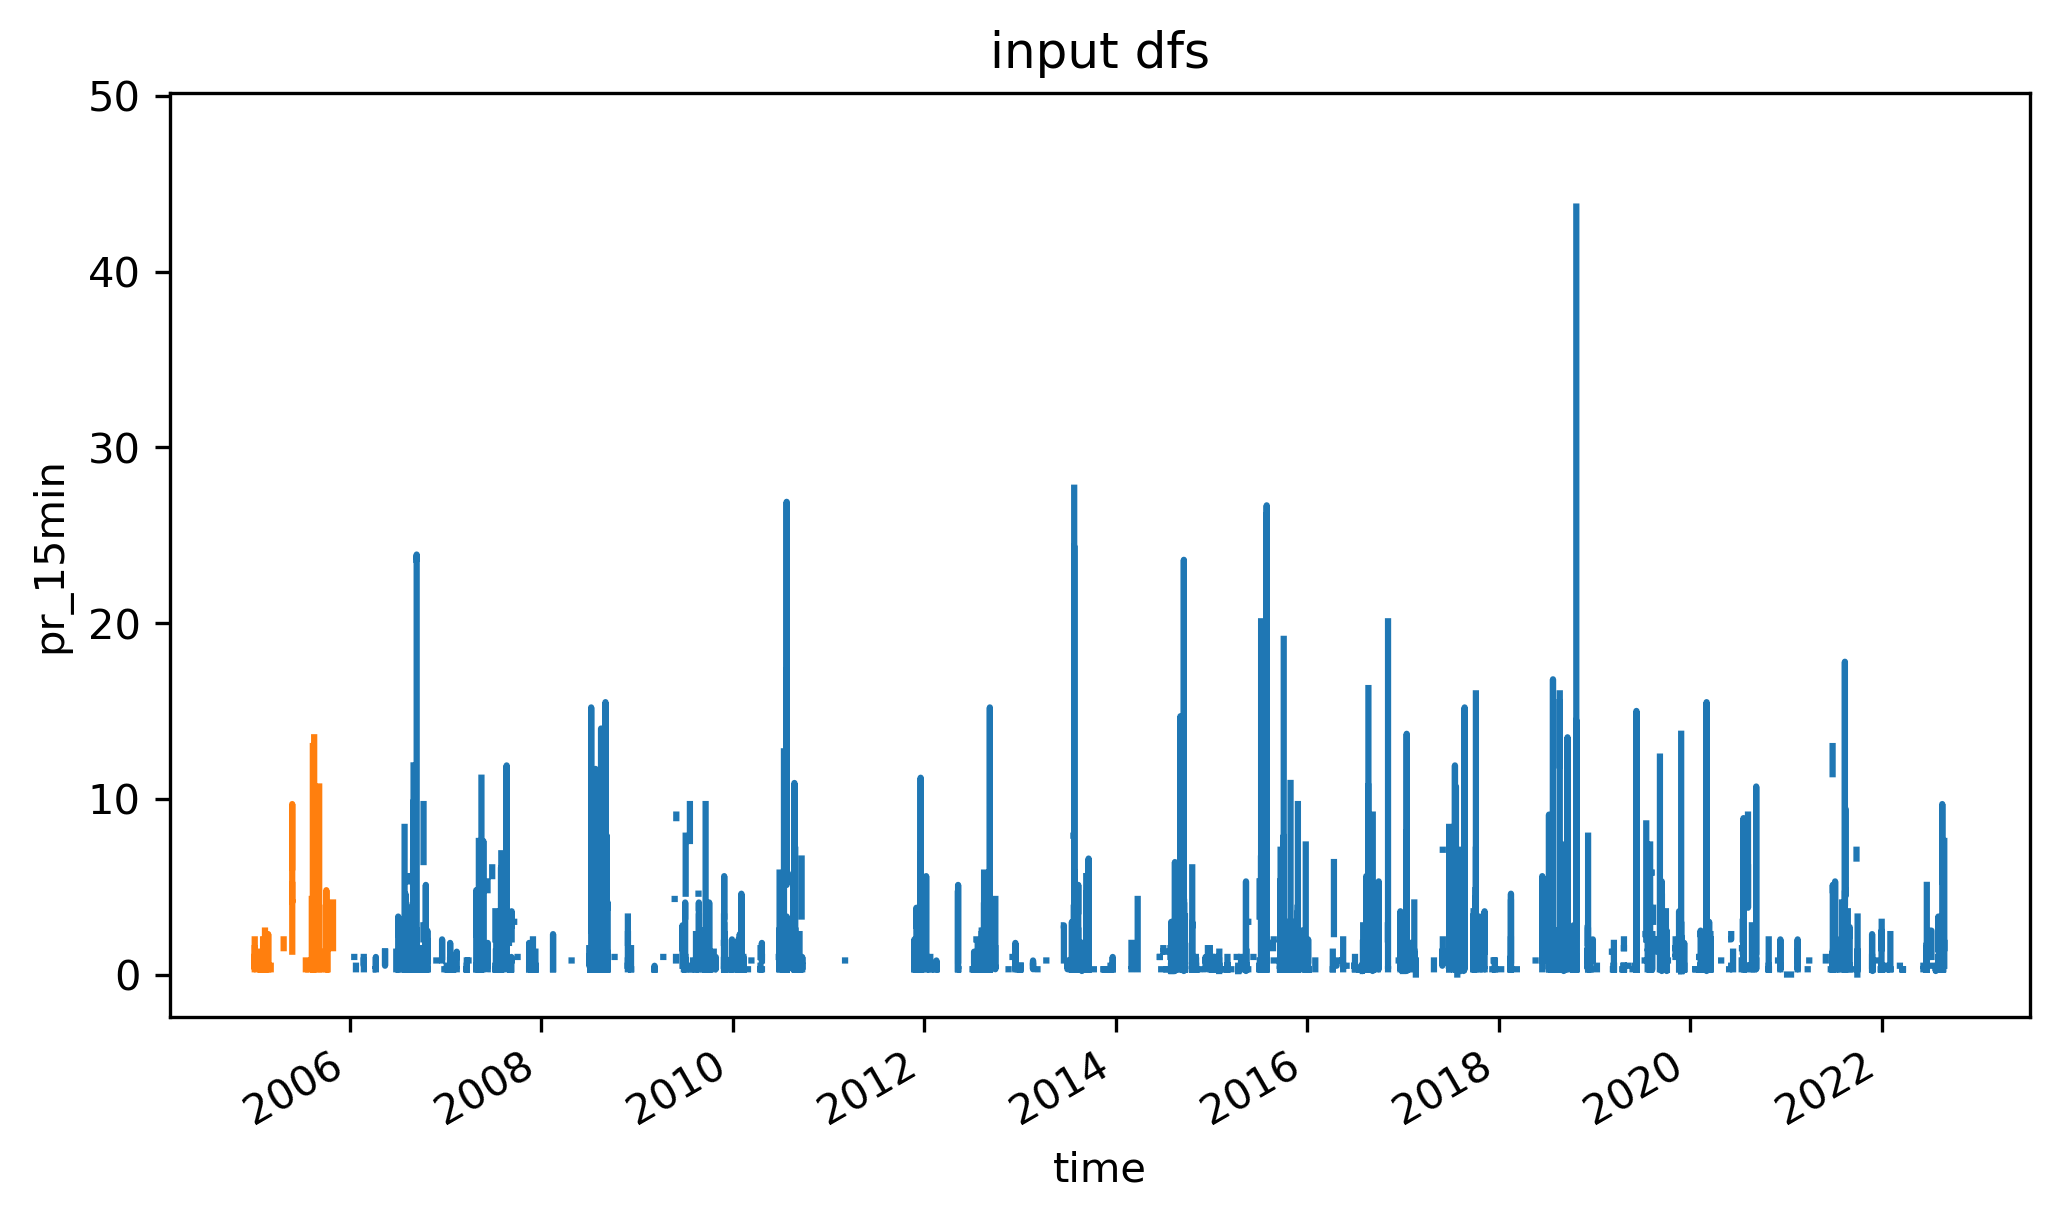

In [41]:
# Create a figure with a specific size
plt.figure(figsize=(8, 4))

# Plotting the time series of given dataframe
plt.plot(df_new["time"], df_new["pr"])

# Plotting the time series of given dataframe
plt.plot(df_old["time"], df_old["pr"])

# Giving title to the chart using plt.title
plt.title("input dfs")

# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha="right")

# Providing x and y label to the chart
plt.xlabel("time")
plt.ylabel("pr_15min")

plt.show()

Plot the output dataset

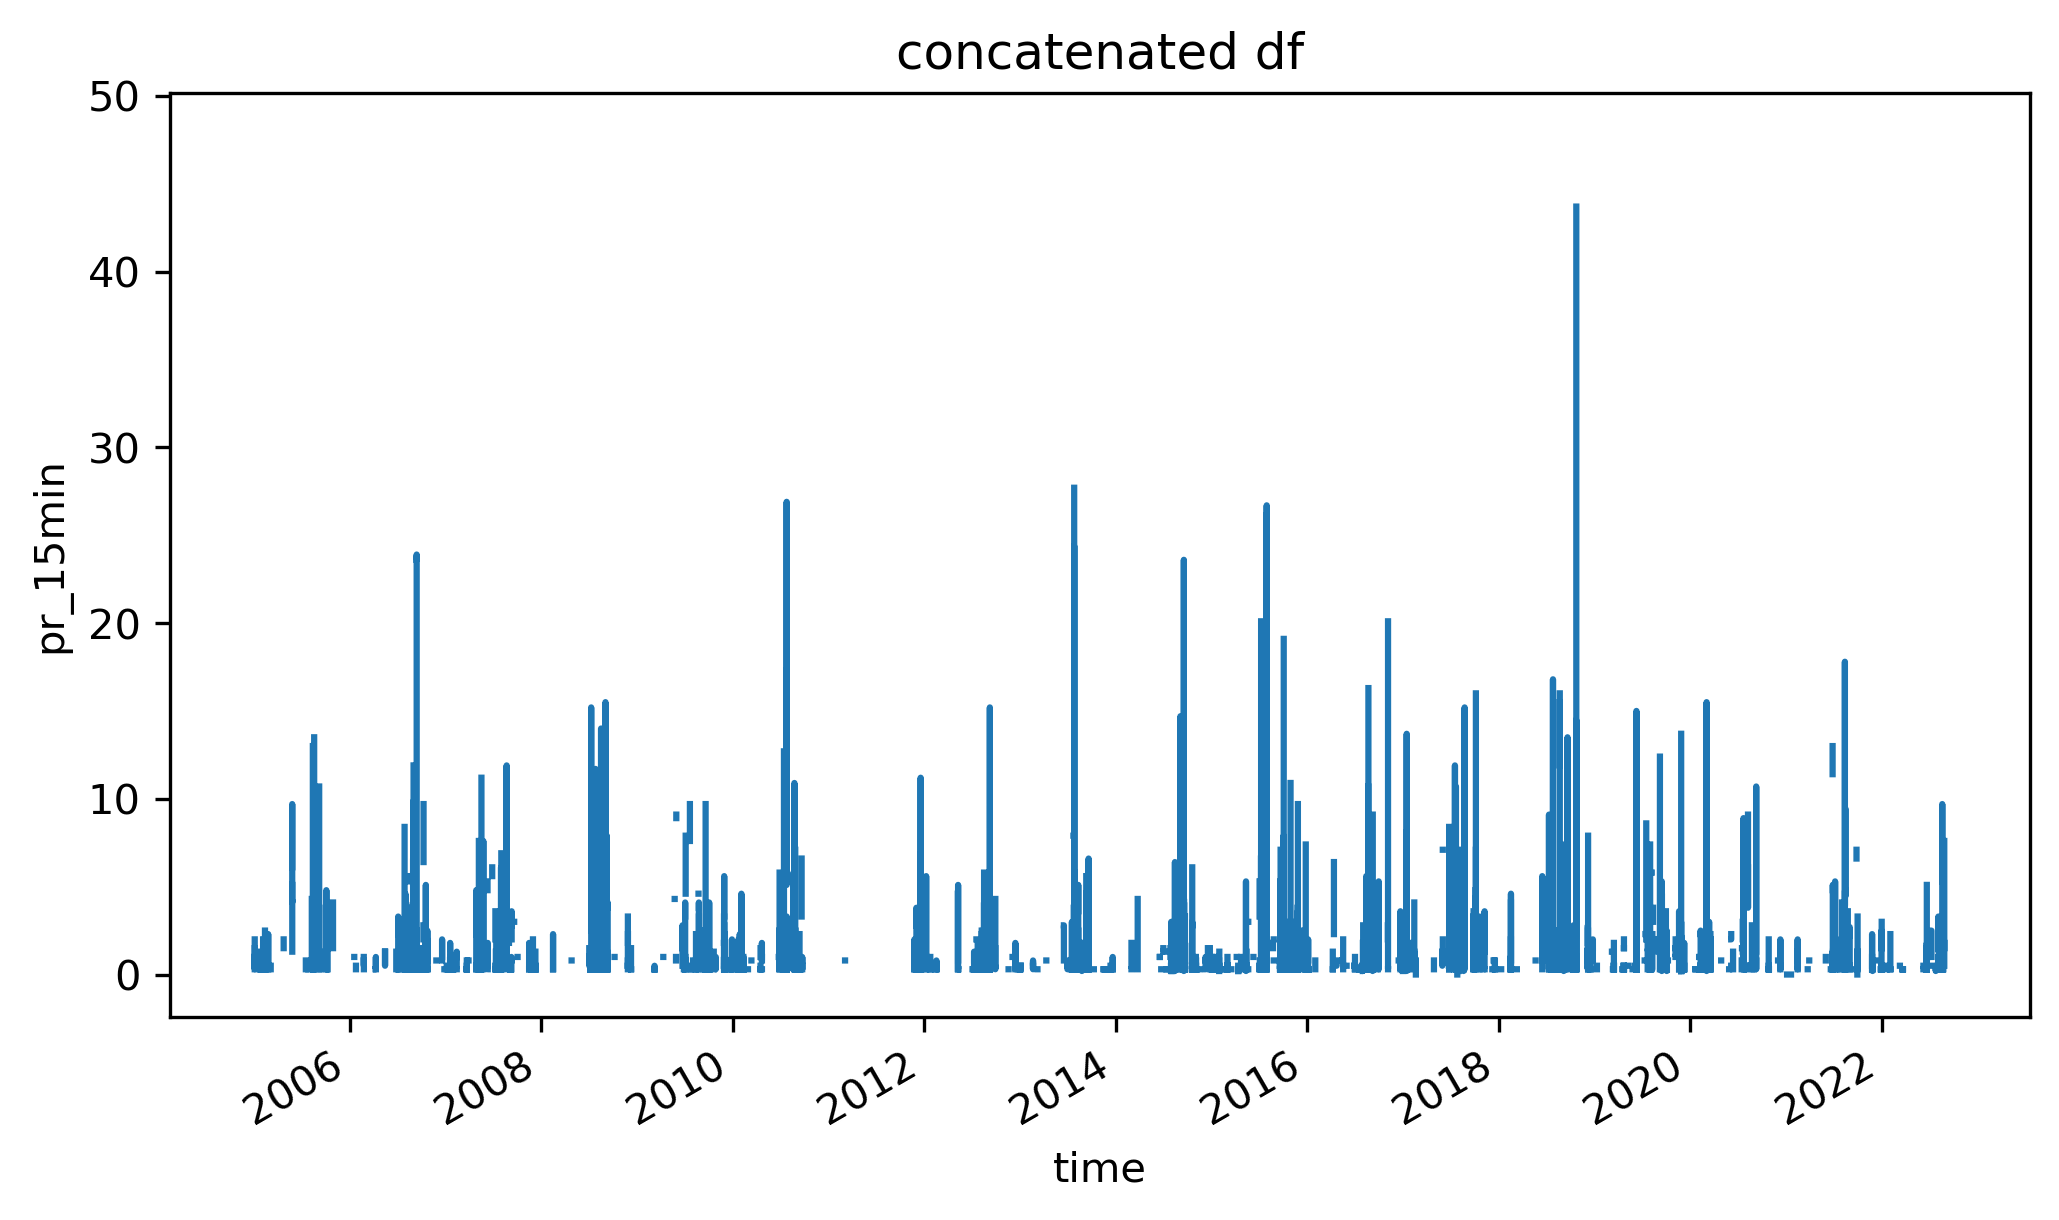

In [42]:
# Create a figure with a specific size
plt.figure(figsize=(8, 4))

# Plotting the time series of given dataframe
plt.plot(df_concat["time"], df_concat["pr"])

# Giving title to the chart using plt.title
plt.title("concatenated df")

# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha="right")

# Providing x and y label to the chart
plt.xlabel("time")
plt.ylabel("pr_15min")

plt.show()

## Step 4: Mark stations that have been concatenated